# Notebook Exploration

## Functions

In [1]:
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd

def evaluate_and_log_metrics(experiment_name, lda_model_title, corpus_test_title, lda_transformed_title_test):
    
    # calculer la log-perplexité
    log_perplexity_title = lda_model_title.log_perplexity(lda_transformed_title_test)
    
    # calculer la perplexité à partir de la log-perplexité
    perplexity_title = np.exp(-log_perplexity_title / len(corpus_test_title))
    
    print(f"Log-Perplexity: {log_perplexity_title}")
    print(f"Perplexity: {perplexity_title}")

    with mlflow.start_run():
        mlflow.set_experiment(experiment_name)
        mlflow.log_metric("Log-Perplexity", log_perplexity_title)
        mlflow.log_metric("Perplexity", perplexity_title)

    return log_perplexity_title, perplexity_title

## Split dataset

In [2]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("dataset_cleaned.csv")
train_data, test_data = train_test_split(data, test_size=0.2)

## LDA (Latent Dirichlet allocation)

### Préparer LDA sur les titres (pour un modèle simple)

In [61]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# train
text_data_train_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in train_data['title_lemmatized']]

text_data_train_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_train_title]

# test
text_data_test_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in test_data['title_lemmatized']]

text_data_test_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_test_title]

dictionary_train_title = Dictionary(text_data_train_title)
corpus_train_title = [dictionary_train_title.doc2bow(word_list) for word_list in text_data_train_title]

dictionary_test_title = Dictionary(text_data_test_title)
corpus_test_title = [dictionary_test_title.doc2bow(word_list) for word_list in text_data_test_title]

# Entraînement du modèle LDA sur le train set
lda_model_title = LdaModel(corpus_train_title, num_topics=5, id2word=dictionary_train_title, passes=10)

# mots associés à chaque topic pour le titre
print("Mots associés à chaque topic pour le titre:")
for topic_idx, topic in lda_model_title.print_topics():
    print(f"Topic {topic_idx + 1}: {topic}")

# LDA pour transformer les données de test sur l'ensemble de test
lda_transformed_title_test = lda_model_title[corpus_test_title]

# calculer la log-perplexité
log_perplexity_title = lda_model_title.log_perplexity(lda_transformed_title_test)

# calculer la perplexité à partir de la log-perplexité
perplexity_title = np.exp(-log_perplexity_title / len(corpus_test_title))

print(f"Log-Perplexity: {log_perplexity_title}")
print(f"Perplexity: {perplexity_title}")

Mots associés à chaque topic pour le titre:
Topic 1: 0.015*"string" + 0.012*"type" + 0.012*"object" + 0.011*"using" + 0.010*"convert" + 0.010*"value" + 0.010*"javascript" + 0.009*"function" + 0.008*"array" + 0.008*"get"
Topic 2: 0.012*"using" + 0.011*"spring" + 0.010*"change" + 0.010*"ios" + 0.009*"view" + 0.008*"return" + 0.007*"request" + 0.007*"swift" + 0.007*"jquery" + 0.007*"data"
Topic 3: 0.027*"file" + 0.016*"error" + 0.013*"using" + 0.012*"studio" + 0.011*"android" + 0.011*"files" + 0.010*"code" + 0.009*"find" + 0.008*"windows" + 0.008*"line"
Topic 4: 0.031*"c" + 0.024*"vs" + 0.017*"use" + 0.010*"java" + 0.010*"web" + 0.009*"api" + 0.009*"net" + 0.008*"set" + 0.007*"application" + 0.007*"button"
Topic 5: 0.015*"sql" + 0.014*"using" + 0.013*"multiple" + 0.012*"list" + 0.011*"way" + 0.011*"server" + 0.009*"difference" + 0.009*"database" + 0.009*"use" + 0.009*"data"
Log-Perplexity: -17.757421387340738
Perplexity: 1.0019590884926033


In [62]:
# Afficher les mots correspondant à chaque index dans le premier document
for (index, freq) in corpus_train_title[0]:
    print(f"Mot: {dictionary_train_title[index]}, Fréquence: {freq}")

Mot: 10, Fréquence: 1
Mot: javas, Fréquence: 1
Mot: osname, Fréquence: 1
Mot: windows, Fréquence: 1


### Trouver le nombre de topics avec la Perplexité (Avec title seulement)

In [111]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import numpy as np
from gensim.models import CoherenceModel

# train
text_data_train_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in train_data['title_lemmatized']]

text_data_train_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_train_title]

# test
text_data_test_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in test_data['title_lemmatized']]

text_data_test_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_test_title]

dictionary_train_title = Dictionary(text_data_train_title)
dictionary_test_title = Dictionary(text_data_test_title)

dictionary_train_title.filter_extremes(no_below=5, no_above=0.6)
dictionary_test_title.filter_extremes(no_below=5, no_above=0.6)

corpus_train_title = [dictionary_train_title.doc2bow(word_list) for word_list in text_data_train_title]
corpus_test_title = [dictionary_test_title.doc2bow(word_list) for word_list in text_data_test_title]

# nombres de topics à tester
num_topics_list = [5, 10, 20, 30, 50, 80, 120]

perplexity_scores = []
coherence_scores = []

for num_topics in num_topics_list:
    lda_model_title = LdaModel(corpus_train_title, num_topics=num_topics, id2word=dictionary_train_title, passes=10)

    # score de perpléxité
    log_perplexity_title = lda_model_title.log_perplexity(corpus_test_title)
    perplexity_title = np.exp(-log_perplexity_title / len(corpus_test_title))
    perplexity_scores.append(perplexity_title)

    # score de cohérence
    coherence_model_title = CoherenceModel(model=lda_model_title, texts=text_data_train_title, dictionary=dictionary_train_title, coherence='c_v')
    coherence_score = coherence_model_title.get_coherence()
    coherence_scores.append(coherence_score)

    print("Nombre de Topics:", num_topics)
    print("  Score de Perplexité:", perplexity_title)
    print("  Score de Cohérence:", coherence_score)
    print()

best_num_topics = num_topics_list[np.argmin(perplexity_scores)]
best_num_topics_coh = num_topics_list[np.argmax(coherence_scores)]

print(f"Le nombre optimal de topics selon la perplexité est : {best_num_topics}")
print(f"Le nombre optimal de topics selon la cohérence des topics est : {best_num_topics_coh}")


Nombre de Topics: 5
  Score de Perplexité: 1.001012547385187
  Score de Cohérence: 0.2611603115430687
Nombre de Topics: 10
  Score de Perplexité: 1.0010435667940167
  Score de Cohérence: 0.28802283590165634
Nombre de Topics: 20
  Score de Perplexité: 1.0010619660021494
  Score de Cohérence: 0.37969446451572486
Nombre de Topics: 30
  Score de Perplexité: 1.0010974298242068
  Score de Cohérence: 0.5049202757731097
Nombre de Topics: 50
  Score de Perplexité: 1.0012279531338542
  Score de Cohérence: 0.5698340215521982
Nombre de Topics: 80
  Score de Perplexité: 1.0023716264303157
  Score de Cohérence: 0.5695204164603872
Nombre de Topics: 120
  Score de Perplexité: 1.0083482987265526
  Score de Cohérence: 0.6225702047141427

Le nombre optimal de topics selon la perplexité est : 5
Le nombre optimal de topics selon la cohérence des topics est : 120


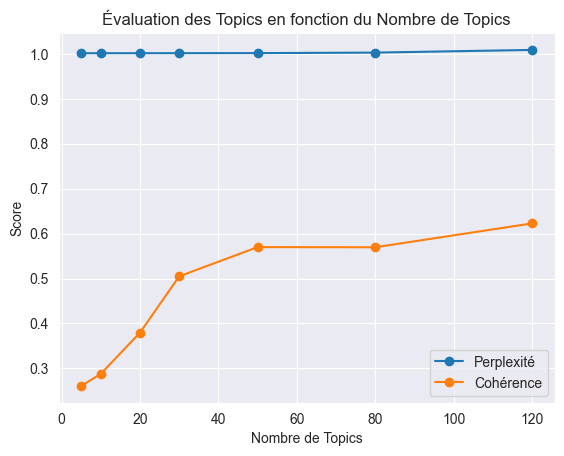

In [112]:
import matplotlib.pyplot as plt

# scores de perplexité
plt.plot(num_topics_list, perplexity_scores, marker='o', linestyle='-', label='Perplexité')

# scores de cohérence
plt.plot(num_topics_list, coherence_scores, marker='o', linestyle='-', label='Cohérence')

plt.xlabel('Nombre de Topics')
plt.ylabel('Score')
plt.title('Évaluation des Topics en fonction du Nombre de Topics')
plt.legend()
plt.grid(True)
plt.show()


In [64]:
print(corpus_train_title)


[[(0, 1), (1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)], [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)], [(15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)], [(23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)], [(30, 1), (31, 1)], [(32, 1), (33, 1), (34, 1), (35, 1)], [(36, 1), (37, 1), (38, 1), (39, 1), (40, 1)], [(6, 1), (41, 1), (42, 1)], [(43, 1), (44, 1), (45, 1)], [(46, 1), (47, 1), (48, 1), (49, 1), (50, 1)], [(31, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1)], [(56, 1)], [(10, 1), (57, 1), (58, 1)], [(24, 1), (49, 1), (59, 1), (60, 1), (61, 1)], [(62, 1), (63, 1), (64, 1), (65, 1), (66, 1)], [(67, 1), (68, 1), (69, 1), (70, 1), (71, 1)], [(72, 1), (73, 1), (74, 1)], [(13, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1)], [(43, 1), (69, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1)], [(2, 1), (13, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1)], [(92, 1), (93, 1), (94, 1), (95, 1)], [(96, 1), (97

### Trouver le nombre de topics avec la Perplexité (Avec title et body)

In [113]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import numpy as np

# train
text_data_train_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in train_data['title_lemmatized']]
text_data_train_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_train_title]

text_data_train_body = [[word.strip("[]'") for word in doc.split(', ')] for doc in train_data['body_lemmatized']]
text_data_train_body = [[word for phrase in doc for word in phrase.split()] for doc in text_data_train_body]

text_data_train_combined = [title + body for title, body in zip(text_data_train_title, text_data_train_body)]

# test
text_data_test_title = [[word.strip("[]'") for word in doc.split(', ')] for doc in test_data['title_lemmatized']]
text_data_test_title = [[word for phrase in doc for word in phrase.split()] for doc in text_data_test_title]

text_data_test_body = [[word.strip("[]'") for word in doc.split(', ')] for doc in test_data['body_lemmatized']]
text_data_test_body = [[word for phrase in doc for word in phrase.split()] for doc in text_data_test_body]

text_data_test_combined = [title + body for title, body in zip(text_data_test_title, text_data_test_body)]


dictionary_train_combined = Dictionary(text_data_train_combined)
dictionary_test_combined = Dictionary(text_data_test_combined)

dictionary_train_combined.filter_extremes(no_below=5, no_above=0.6)
dictionary_test_combined.filter_extremes(no_below=5, no_above=0.6)

corpus_train_combined = [dictionary_train_combined.doc2bow(word_list) for word_list in text_data_train_combined]
corpus_test_combined = [dictionary_test_combined.doc2bow(word_list) for word_list in text_data_test_combined]

num_topics_list = [5, 10, 20, 30, 50, 80, 120]
perplexity_scores_combined = []
coherence_scores_combined = []

for num_topics in num_topics_list:    
    lda_model_combined = LdaModel(corpus_train_combined, num_topics=num_topics, id2word=dictionary_train_combined, passes=10)

    log_perplexity_combined = lda_model_combined.log_perplexity(corpus_test_combined)
    perplexity_combined = np.exp(-log_perplexity_combined / len(corpus_test_combined))
    perplexity_scores_combined.append(perplexity_combined)

    # score de cohérence
    coherence_model_combined = CoherenceModel(model=lda_model_combined, texts=text_data_train_combined, dictionary=dictionary_train_combined, coherence='c_v')
    coherence_score_combined = coherence_model_combined.get_coherence()
    coherence_scores_combined.append(coherence_score_combined)

    print("Nombre de Topics:", num_topics)
    print("  Score de Perplexité:", perplexity_combined)
    print("  Score de Cohérence:", coherence_score_combined)
    print()

best_num_topics_combined = num_topics_list[np.argmin(perplexity_scores_combined)]
best_num_topics_coh_combined = num_topics_list[np.argmax(coherence_scores_combined)]

print(f"Le nombre optimal de topics selon la perplexité est : {best_num_topics_combined}")
print(f"Le nombre optimal de topics selon la cohérence des topics est : {best_num_topics_coh_combined}")


Nombre de Topics: 5
  Score de Perplexité: 1.0010637256695685
  Score de Cohérence: 0.4945304382634266
Nombre de Topics: 10
  Score de Perplexité: 1.0010873515942214
  Score de Cohérence: 0.5530752330451052
Nombre de Topics: 20
  Score de Perplexité: 1.0011333405076888
  Score de Cohérence: 0.5530309639947883
Nombre de Topics: 30
  Score de Perplexité: 1.0011783948301507
  Score de Cohérence: 0.5600517147666625
Nombre de Topics: 50
  Score de Perplexité: 1.0012362768701681
  Score de Cohérence: 0.5268320832137845
Nombre de Topics: 80
  Score de Perplexité: 1.0013675537136781
  Score de Cohérence: 0.4700481598616406
Nombre de Topics: 120
  Score de Perplexité: 1.001457830540892
  Score de Cohérence: 0.4315939478941698

Le nombre optimal de topics selon la perplexité est : 5
Le nombre optimal de topics selon la cohérence des topics est : 30


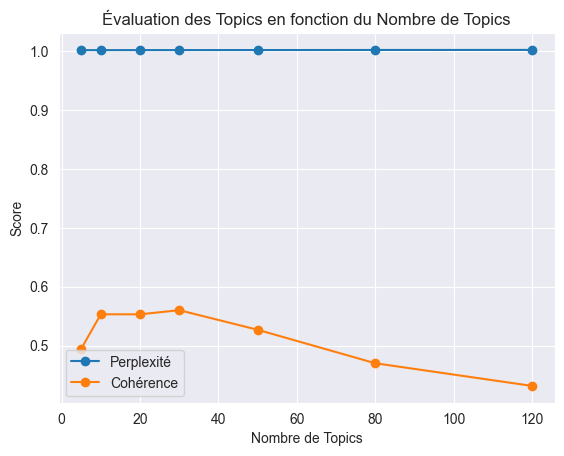

In [114]:
import matplotlib.pyplot as plt

# scores de perplexité
plt.plot(num_topics_list, perplexity_scores_combined, marker='o', linestyle='-', label='Perplexité')

# scores de cohérence
plt.plot(num_topics_list, coherence_scores_combined, marker='o', linestyle='-', label='Cohérence')

plt.xlabel('Nombre de Topics')
plt.ylabel('Score')
plt.title('Évaluation des Topics en fonction du Nombre de Topics')
plt.legend()
plt.grid(True)
plt.show()


In [126]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# nombre de mots clés à afficher pour chaque topic
num_words = 30

# nombre de topics
num_topics = 20

# transformer les données textuelles en une seule chaîne de caractères par document
text_data_train_title_str = [' '.join(doc) for doc in text_data_train_title]
text_data_test_title_str = [' '.join(doc) for doc in text_data_test_title]

# transformer les données textuelles en une liste de listes de mots
text_data_train_title_tokens = [doc.split() for doc in text_data_train_title_str]

# conversion de chaque mot en Unicode 
text_data_train_title_unicode = [[str(word) for word in doc] for doc in text_data_train_title_tokens]

# dictionnaire gensim à partir des textes d'entraînement
dictionary_selected = Dictionary(text_data_train_title_unicode)

# ne pas garder les outliers
dictionary_selected.filter_extremes(no_below=5, no_above=0.6)

# transformer la matrice de termes en un corpus Gensim
corpus_train_selected = [dictionary_selected.doc2bow(tokens) for tokens in text_data_train_title_unicode]

# créer un modèle LDA et l'entraîner sur les données
lda_selected = LdaModel(corpus=corpus_train_selected, num_topics=num_topics, id2word=dictionary_selected, passes=10,random_state=42)

# mots clés pour chaque topic
for topic_idx in range(num_topics):
    print(f"Topic {topic_idx + 1}:")
    print(lda_selected.show_topic(topic_idx, topn=num_words))
    print()



Topic 1:
[('android', 0.13903432), ('library', 0.030491991), ('possible', 0.030417122), ('application', 0.028273217), ('failed', 0.028009418), ('css', 0.02760142), ('studio', 0.026326563), ('service', 0.020756343), ('gradle', 0.020075377), ('video', 0.018691491), ('error', 0.016697705), ('html5', 0.015602133), ('message', 0.014699209), ('compile', 0.013834407), ('unique', 0.013260954), ('start', 0.013251085), ('webpack', 0.0129839955), ('app', 0.012458014), ('using', 0.012049073), ('scroll', 0.011655035), ('apk', 0.011141764), ('resize', 0.011015775), ('2008', 0.009751722), ('hide', 0.009677259), ('installed', 0.00964012), ('lists', 0.009568671), ('state', 0.009211929), ('existing', 0.009017275), ('decimal', 0.008365818), ('resolve', 0.007932574)]

Topic 2:
[('way', 0.07106396), ('array', 0.06384104), ('visual', 0.04340534), ('studio', 0.04223893), ('working', 0.037738476), ('remove', 0.0280856), ('iphone', 0.026750375), ('elements', 0.024637647), ('best', 0.023709197), ('fix', 0.02311

## Mapping manuel des noms des topics après analyse des corpus

In [129]:
topic_names = {
    0: "mobile-development",
    1: "web",
    2: "java",
    3: "software-design",
    4: "python",
    5: "server-side",
    6: "frameworks",
    7: "code-structure",
    8: "javascript",
    9: "paradigms",
    10: "file-handling",
    11: "ios",
    12: "spring",
    13: "devtools",
    14: "user-interface",
    15: "methodology",
    16: "configuration",
    17: "data-modeling",
    18: "asp.net",
    19: "optimization"
}


## Prédiction des 5 meilleures catégories / tags

In [139]:
from gensim.utils import simple_preprocess

# prétraiter le texte
def simple_preprocess_text(text):
    return simple_preprocess(text)

# distributions de probabilité des topics pour une phrase donnée
def get_topic_distribution(model, dictionary, text):
    text_tokens = simple_preprocess_text(text)
    text_bow = dictionary.doc2bow(text_tokens)
    return model.get_document_topics(text_bow)

phrase = "Accuracy issue in classification model"

# distributions de probabilité des topics pour la phrase
topic_distribution = get_topic_distribution(lda_selected, dictionary_selected, phrase)

# trier les topics par probabilité
sorted_topics = sorted(topic_distribution, key=lambda x: x[1], reverse=True)

# sélectionner les cinq premiers topics
top_5_topics = sorted_topics[:5]

for topic in top_5_topics:
    topic_idx, prob = topic
    topic_name = topic_names.get(topic_idx, f"Topic {topic_idx}")
    print(f"{topic_name}: Probability: {prob}")
    print(lda_selected.show_topic(topic_idx, topn=num_words))
    print()

data-modeling: Probability: 0.3499992787837982
[('string', 0.07741673), ('difference', 0.055002257), ('object', 0.049672835), ('list', 0.043949395), ('value', 0.039142363), ('model', 0.030132478), ('key', 0.02940635), ('laravel', 0.029359458), ('table', 0.02607395), ('objects', 0.025140747), ('column', 0.02358494), ('memory', 0.021819213), ('attribute', 0.019203117), ('get', 0.01861766), ('xml', 0.016103271), ('using', 0.015587887), ('whats', 0.015358585), ('data', 0.014983205), ('json', 0.014528796), ('sort', 0.014399736), ('convert', 0.0132905105), ('binary', 0.012681222), ('django', 0.012627269), ('query', 0.011276901), ('extension', 0.010774644), ('index', 0.0101969335), ('insert', 0.009804902), ('filter', 0.008818251), ('names', 0.008034746), ('raw', 0.00781521)]

user-interface: Probability: 0.34999674558639526
[('install', 0.055067077), ('element', 0.039896913), ('path', 0.036162786), ('x', 0.030609531), ('invalid', 0.030607807), ('disable', 0.027837547), ('mac', 0.026533244), (

In [8]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.lda_model

# Visualisation pour le titre
pyLDAvis.enable_notebook()
vis_title = pyLDAvis.lda_model.prepare(lda_selected, X_title_test, vectorizer_title, mds='tsne')
pyLDAvis.display(vis_title)

ModuleNotFoundError: No module named 'pyLDAvis'

In [ ]:
num_topics = M_topics_words.shape[0]
num_top_words = 10

for topic_idx in range(num_topics):
    top_words_idx = M_topics_words[topic_idx].argsort()[:-num_top_words - 1:-1]
    top_words = [feature_names_title[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


In [ ]:
num_questions = M_quest_topics_train.shape[0]
num_top_topics = 3

for question_idx in range(num_questions):
    top_topics_idx = M_quest_topics_train[question_idx].argsort()[:-num_top_topics - 1:-1]
    print(f"Question {question_idx + 1} - Topics Principaux : {', '.join(map(str, top_topics_idx))}")
